In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sqlite3
import geopandas as gpd

In [2]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [12, 5]

In [3]:
# connect to challenge.db
con = sqlite3.connect('challenge.db')
cur = con.cursor()

# convert accesss table to df
all_access = cur.execute('select * from access')
access_cols = list(map(lambda x: x[0], all_access.description))
access_df = pandas.DataFrame(all_access.fetchall(), columns=access_cols)

# convert variable_list table to df
all_variable_list = cur.execute('select * from variable_list')
variable_list_cols = list(map(lambda x: x[0], all_variable_list.description))
variable_list_df = pandas.DataFrame(all_variable_list.fetchall(), columns=variable_list_cols)

# convert five_hundred_cities table to df
all_five_hundred_cities = cur.execute('select * from five_hundred_cities')
five_hundred_cities_cols = list(map(lambda x: x[0], all_five_hundred_cities.description))
five_hundred_cities_df = pandas.DataFrame(
    all_five_hundred_cities.fetchall(), columns=five_hundred_cities_cols
)

con.close()

In [4]:
# map access variable codes to long name
col_to_variable = dict()
for col in access_df.columns:
    variable_name = variable_list_df.loc[variable_list_df['Variable Code'] == col]
    if len(variable_name) > 0:
        col_to_variable[col] = variable_name['Variable Name'].item()
for item in col_to_variable.items():
    print(item)

('LACCESS_POP10', 'Population, low access to store, 2010')
('LACCESS_POP15', 'Population, low access to store, 2015')
('PCH_LACCESS_POP_10_15', 'Population, low access to store (% change), 2010 -15')
('PCT_LACCESS_POP10', 'Population, low access to store (%), 2010')
('PCT_LACCESS_POP15', 'Population, low access to store (%), 2015')
('LACCESS_LOWI10', 'Low income & low access to store, 2010')
('LACCESS_LOWI15', 'Low income & low access to store, 2015')
('PCH_LACCESS_LOWI_10_15', 'Low income & low access to store (% change), 2010 - 15')
('PCT_LACCESS_LOWI10', 'Low income & low access to store (%), 2010')
('PCT_LACCESS_LOWI15', 'Low income & low access to store (%), 2015')
('LACCESS_HHNV10', 'Households, no car & low access to store, 2010')
('LACCESS_HHNV15', 'Households, no car & low access to store, 2015')
('PCH_LACCESS_HHNV_10_15', 'Households, no car & low access to store (% change), 2010 - 15')
('PCT_LACCESS_HHNV10', 'Households, no car & low access to store (%), 2010')
('PCT_LACCESS

In [5]:
# find correlation coefficient between low food access % and health indicators

# make lookup for access by fips
low_acces_pct_by_fips = {row['FIPS']: row['PCT_LACCESS_POP15'] for index, row in access_df.iterrows()}
corr_coefs = []
county_laccess_15 = five_hundred_cities_df.apply(
            lambda row: low_acces_pct_by_fips[row['TractFIPS']//1e6], axis=1)
for col_name in five_hundred_cities_cols:
    if 'CrudePrev' in col_name:
        corr_coefs.append((col_name, county_laccess_15.corr(five_hundred_cities_df[col_name])))

In [6]:
# find most strongly correlated health indicators
corr_coefs.sort(key=lambda x: x[1], reverse=True)
corr_coefs

[('OBESITY_CrudePrev', 0.3376066103286179),
 ('ARTHRITIS_CrudePrev', 0.2637766205265153),
 ('CSMOKING_CrudePrev', 0.2216515863739442),
 ('COPD_CrudePrev', 0.2211017884853389),
 ('BPHIGH_CrudePrev', 0.21001332042345078),
 ('LPA_CrudePrev', 0.1579724481993615),
 ('MHLTH_CrudePrev', 0.1570627155353809),
 ('CHD_CrudePrev', 0.14989047493943802),
 ('TEETHLOST_CrudePrev', 0.13365526715799966),
 ('COREM_CrudePrev', 0.1329809023544757),
 ('PHLTH_CrudePrev', 0.1309277963000703),
 ('HIGHCHOL_CrudePrev', 0.1255427533234302),
 ('ACCESS2_CrudePrev', 0.11252682021050464),
 ('BPMED_CrudePrev', 0.10945995569216226),
 ('CANCER_CrudePrev', 0.10235435381149915),
 ('CASTHMA_CrudePrev', 0.10033050933743147),
 ('STROKE_CrudePrev', 0.09912800865841254),
 ('DIABETES_CrudePrev', 0.08504208934227897),
 ('COREW_CrudePrev', 0.0781777397381725),
 ('KIDNEY_CrudePrev', 0.060609815466818366),
 ('COLON_SCREEN_CrudePrev', -0.012252480212411543),
 ('CHECKUP_CrudePrev', -0.030947803417277334),
 ('PAPTEST_CrudePrev', -0.04

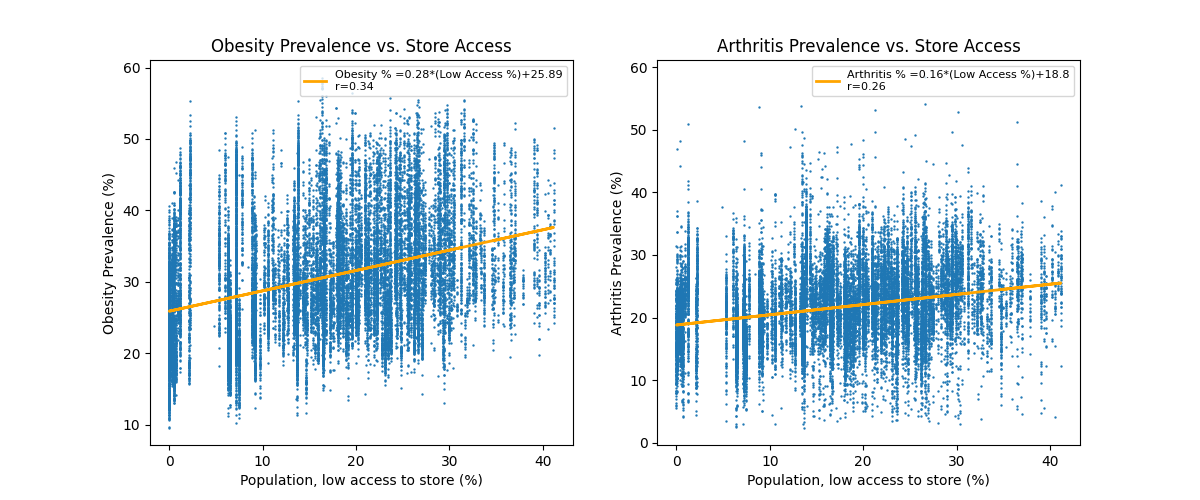

In [7]:
# show the relationship between most strongly correlated indicators and low access %
label_names = {
    'OBESITY_CrudePrev': 'Obesity',
    'ARTHRITIS_CrudePrev': 'Arthritis',
    'CSMOKING_CrudePrev': 'Smoking',
    'COPD_CrudePrev': 'COPD',
    'BPHIGH_CrudePrev': 'High Blood Pressure',
}

n_indicator = 2 # must be greater than 1
fig, axes = plt.subplots(nrows=1, ncols=n_indicator)

for idx in range(n_indicator):
    indicator_name = corr_coefs[idx][0]
    access_indicator_df = pandas.concat([county_laccess_15, five_hundred_cities_df[indicator_name]], axis=1)
    access_indicator_df.dropna(inplace=True)
    
    # plot indicator % vs low access %
    axes[idx].scatter(access_indicator_df[0], access_indicator_df[indicator_name], s=0.5)
    
    # plot line of best fit
    laccess_np_arr = np.array(access_indicator_df[0])
    indicator_np_arr = np.array(access_indicator_df[indicator_name])
    a, b = np.polyfit(laccess_np_arr, indicator_np_arr, 1)
    axes[idx].plot(laccess_np_arr, a * laccess_np_arr + b, linewidth=2, c='orange',
                   label=f'{label_names[indicator_name]} % ={round(a,2)}*(Low Access %)+{round(b, 2)}\nr={round(corr_coefs[idx][1], 2)}')
    
    axes[idx].set_title(f'{label_names[indicator_name]} Prevalence vs. Store Access')
    axes[idx].set_ylabel(f'{label_names[indicator_name]} Prevalence (%)')
    axes[idx].set_xlabel('Population, low access to store (%)')
    axes[idx].legend(loc='upper right', prop={'size': 8})

In [8]:
# create general health indicator metric based on 500 cities data
# combination of prevalance of different health indicators
health_data_names = [x[0] for x in corr_coefs[:5]]

# sum the prevalence of health indicators to create overall health metric
def calculate_health_metric(row):
    # (% low access /100) * (sum prevalence of health indicators)
    return (low_acces_pct_by_fips[row['TractFIPS']//1e6] / 100) * sum(row[health_data_names])

In [9]:
# calculate metric for all cities
five_hundred_cities_df['health_metric'] = five_hundred_cities_df.apply(
    calculate_health_metric, axis=1
)
top_hundred_by_metric = five_hundred_cities_df.sort_values(
    'health_metric', ascending=False).head(1000)
top_hundred_by_metric

,index,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,...,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation,health_metric
22062,22062,TN,Chattanooga,4714000,47065001600,4714000-47065001600,2481,31.5,"(27.0, 36.1)",41.2,...,30.9,"(28.6, 33.3)",49.8,"(48.2, 51.4)",11.4,"(10.4, 12.4)",48.7,"(40.5, 56.2)","(35.04199223900, -85.3221951713)",88.157573
22064,22064,TN,Chattanooga,4714000,47065001900,4714000-47065001900,3959,30.4,"(26.3, 34.7)",33.1,...,24.1,"(22.0, 26.3)",50.7,"(49.3, 52.0)",8.1,"( 7.3, 9.0)",41.7,"(32.1, 51.4)","(35.00336113190, -85.3148223962)",76.304454
22101,22101,TN,Chattanooga,4714000,47065012200,4714000-47065012200,2908,30.7,"(26.5, 34.9)",32.5,...,23.8,"(21.8, 26.1)",50.8,"(49.0, 52.2)",7.8,"( 7.1, 8.7)",40.5,"(30.6, 50.5)","(35.05887996960, -85.2575670060)",75.810574
22054,22054,TN,Chattanooga,4714000,47065000400,4714000-47065000400,3143,28.5,"(26.0, 31.0)",33.9,...,22.6,"(21.4, 24.0)",50.0,"(49.1, 50.8)",7.9,"( 7.4, 8.4)",37.2,"(32.4, 42.8)","(35.04905535210, -85.2766692831)",75.440164
22066,22066,TN,Chattanooga,4714000,47065002300,4714000-47065002300,1492,32.5,"(30.1, 35.0)",32.7,...,25.5,"(24.0, 27.1)",45.4,"(44.5, 46.3)",6.8,"( 6.3, 7.4)",41.0,"(32.9, 48.6)","(35.00227257010, -85.2979437851)",73.505801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22279,22279,TN,Memphis,4748000,47157009100,4748000-47157009100,2567,38.4,"(35.7, 40.9)",26.8,...,22.6,"(21.5, 23.8)",39.1,"(38.3, 39.8)",5.2,"( 4.9, 5.6)",36.4,"(29.8, 42.8)","(35.17265564050, -89.9098390627)",44.097135
22260,22260,TN,Memphis,4748000,47157007000,4748000-47157007000,3324,26.2,"(22.1, 30.5)",24.5,...,18.2,"(16.6, 19.9)",44.7,"(43.2, 46.1)",4.9,"( 4.4, 5.4)",29.5,"(22.4, 37.3)","(35.11168174880, -89.9561215566)",44.097135
18493,18493,NY,Rochester,3663000,36055001300,3663000-36055001300,1843,27.2,"(23.3, 31.0)",26.0,...,20.8,"(19.1, 22.5)",45.9,"(44.5, 47.2)",5.2,"( 4.7, 5.7)",43.5,"(32.8, 53.2)","(43.16976294310, -77.6070147902)",44.076814
8272,8272,FL,Jacksonville,1235000,12031011600,1235000-12031011600,3850,29.7,"(24.9, 34.6)",34.3,...,22.8,"(20.5, 25.3)",46.7,"(45.1, 48.1)",9.3,"( 8.2, 10.5)",36.8,"(25.4, 47.7)","(30.36942970400, -81.7121248488)",44.073374


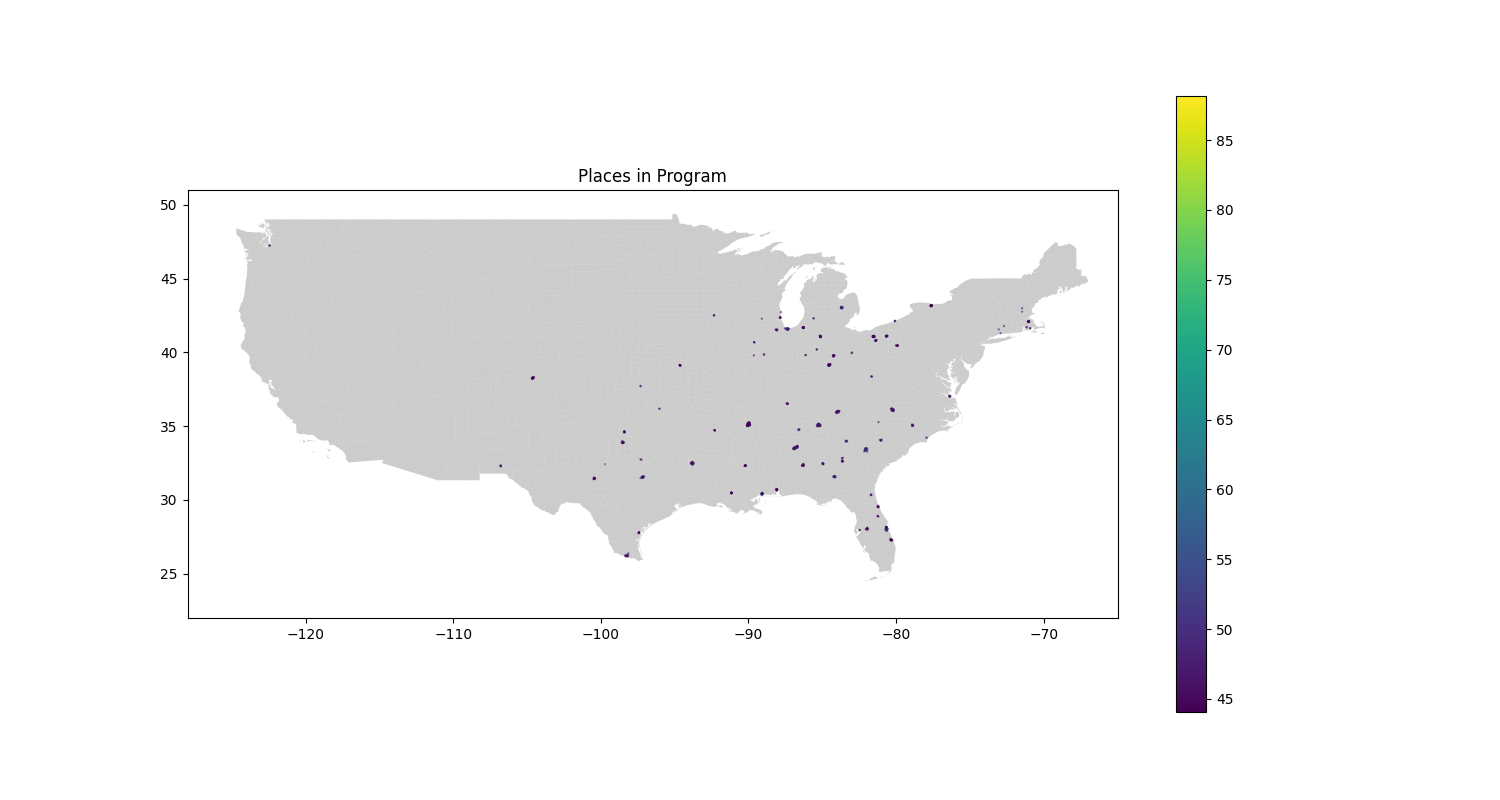

In [10]:
# show top 100 cities

# import map
us_map = gpd.read_file('cb_2018_us_county_5m/cb_2018_us_county_5m.shp')

def parse_string_tup(str):
    no_parens = str[1:-1]
    return [float(x) for x in no_parens.split(',')]


lats = top_hundred_by_metric.apply(lambda row: parse_string_tup(row['Geolocation'])[1], axis=1)
longs = top_hundred_by_metric.apply(lambda row: parse_string_tup(row['Geolocation'])[0], axis=1)
geo_df = gpd.GeoDataFrame(top_hundred_by_metric, geometry = gpd.points_from_xy(lats, longs))

fig, ax = plt.subplots(figsize=(15,8))
us_map.plot(ax=ax, alpha=0.4,color='grey')
geo_df.plot(column='health_metric',ax=ax, alpha=0.5, legend=True,markersize=0.5)
plt.title('Places in Program')
plt.xlim(-128,-65)
plt.ylim(22,51)
plt.show()

In [11]:
# how many people included in the program
total_population = sum(top_hundred_by_metric['Population2010'])
number_laccess = sum(top_hundred_by_metric.apply(
    lambda row: row['Population2010'] * (low_acces_pct_by_fips[row['TractFIPS']//1e6] / 100),
    axis = 1))
national_snap_participation_rate = 0.82
successsful_engagement = national_snap_participation_rate * number_laccess
print(total_population, number_laccess, successsful_engagement)

3034837 1024924.2069928676 840437.8497341514


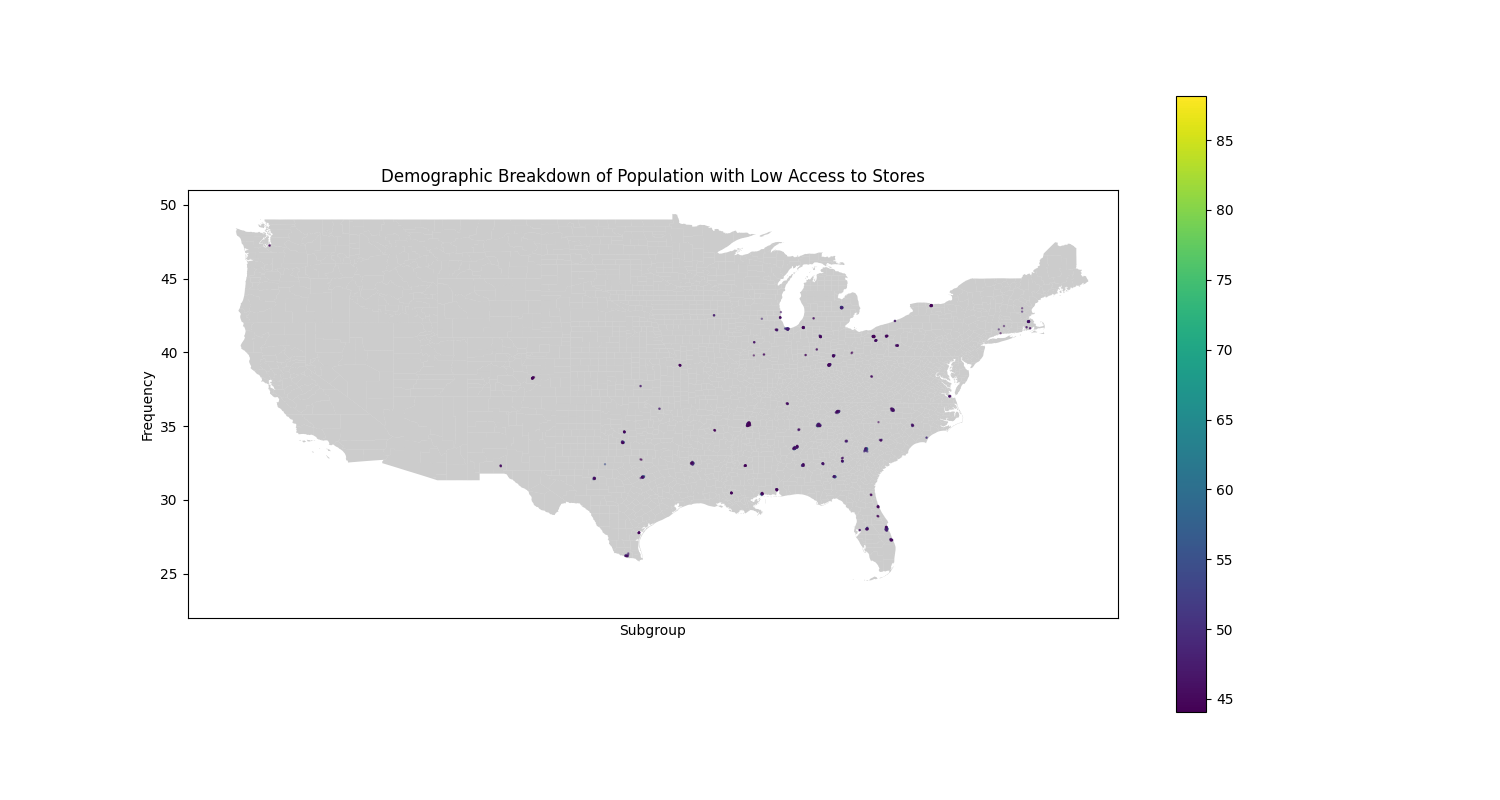

In [12]:
# find demographic of low access population

low_access_counts = access_df[[col for col in access_cols if col[:2] != 'PC' and col[-2:] == '15' and col.count('_') < 3]]
access_sums = low_access_counts.dropna().apply(lambda col: sum(col), axis=0)
low_access_total_pop = access_sums['LACCESS_POP15'].item()
access_pcts = access_sums.drop('LACCESS_POP15').div(low_access_total_pop)
access_pcts.sort_values(ascending=False, inplace=True)
access_pcts.rename(col_to_variable, inplace=True)
access_pcts.rename({col_name: col_name.split(',')[0] for col_name in access_pcts.index}, inplace=True)
access_pcts.rename({'Low income & low access to store': 'Low income'}, inplace=True)
plt.xticks(rotation=-90)
plt.bar(access_pcts.index, access_pcts)
plt.title('Demographic Breakdown of Population with Low Access to Stores')
plt.ylabel('Frequency')
plt.xlabel('Subgroup')
plt.show()